# Cuped

## Table of Contents
* [Introduction](#1)
* [Experiments](#2)
* [Simulation 1](#3)
* [Simulation 2](#4)
* [Simulation 3](#5)
* [Conclusions](#6)

## Introduction <a class="anchor" id="1"></a>

CUPED, which was developed by Deng, Xu, Kohavi, and Walker, is a technique that can be utilized in A/B testing to reduce variance. By utilizing historical "before" data and computing an adjusted evaluation metric, we can lower variance in A/B testing. It appears that several major internet companies, including Bing, Facebook, Netflix, Booking, and Etsy, have adopted CUPED. In this notebook, I will use Monte Carlo simulations of A/B tests to explain how CUPED works.

The main use-case of CUPED is improving the sensitivity of the test by reducing the variance. Then we can exchange the sensitivity for the number of observations, therefore, we can conduct tests of the same strength only with fewer users or with less time.

Let's consider an A/B testing scenario where we are measuring a specific metric. In this setup, we have a total of `N` users that have been randomly split into two groups - A and B. Group A is the control group, while group B is the treatment group. We have measured the metric `X` for each user during the "before" AB test period when the treatment and control groups were the same, and `Y` during the "after" period when the treatment was applied to group B.

To compute a "cuped after":
1. Calculate the covariance `cov(X, Y)` and variance `var(X)`.
2. Calculate theta coefficient `θ = cov(X, Y) / var(X)`.
3. Calculate the mean of metric "before" period `X_mean`. (mean should be as commont as possible, so if you hava AB test on 20% of users calculate mean from whole dataset).
4. Calculate the "cuped after" `Y_cuped = Y - θ * (X - X_mean)`.
5. Use `Y_cuped` next instead of `Y`.

In summary, CUPED helps adjust the "after" metric by considering the variance and covariance of metric in the "before" and "after" periods, and allows for a more accurate evaluation of the A/B test results.

In [3]:
from tqdm import tqdm
import numpy as np
from scipy.stats import ttest_ind, kstest
import pandas as pd
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Experiments <a class="anchor" id="2"></a>

Here I will sample "before" metric from normal distribution, "after" metric would be "before" + small changes, and users from treatment group would get some "lift" in their "after" metric. Users are splitted into control and treatment groups randomly and equally:

In [4]:
def get_samples(
    N: int,
    mean: float,
    std: float,
    std_after: float,
    lift: float
) -> pd.DataFrame:
    
    df = pd.DataFrame()
    df['before'] = np.random.normal(mean, std, N)
    df['after'] = df['before'] + np.random.normal(0, std_after, N)
    df['group'] = 0
    df.loc[np.random.choice(N, N//2, replace=False), 'group'] = 1
    df.loc[df['group'] == 1, 'after'] += lift
    
    return df

In [6]:
get_samples(N=4000, mean=100, std=20, std_after=10, lift=20).head()

,before,after,group
0,87.071392,102.720594,1
1,84.321544,97.728542,0
2,105.115080,121.410045,1
3,90.205394,102.628261,1
4,127.564620,146.716755,1


I fit linear regression with "affter" metric as target and 'before' metric as the only predictor, and take resulting coefficient as theta. Mean is computed from all "before" data: 

In [5]:
def cuped(df: pd.DataFrame, use_theta: bool=True) -> pd.DataFrame:
    
    if use_theta:
        theta = smf.ols('after ~ before', data=df).fit().params[1]
    else:
        theta = 1
        
    df['cuped'] = df['after'] - theta * (df['before'] - np.mean(df['before']))
    
    return df

Here I make Monte-Carlo sumulation, computing variances of default metric and cuped one. It can be seen from the plot that average variance significantly decreases when it is cuped. We can already conclude that the sensitivity of the test increases and the results will improve on a metric with a smaller variance:

100%|█████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.11it/s]


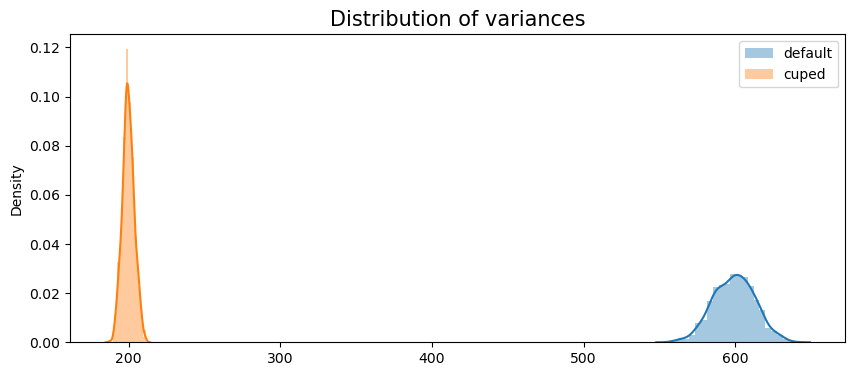

In [4]:
var_default = []
var_cuped = []

for _ in tqdm(range(1000)):
    df = get_samples(N=4000, mean=100, std=20, std_after=10, lift=20)
    df = cuped(df)
    var_default.append(np.var(df['after']))
    var_cuped.append(np.var(df['cuped']))

plt.subplots(figsize=(10,4))
sns.distplot(var_default, label='default')
sns.distplot(var_cuped, label='cuped')
plt.title('Distribution of variances', fontsize=15)
plt.legend();

## Simulation 1 <a class="anchor" id="3"></a>

Here I will simulate N times AB test and conduct t-test on default and cuped metrics:

In [5]:
def simulate(N: int, generation_conf: dict) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    pvalues_default = []
    pvalues_cuped = []
    lifts_default = []
    lifts_cuped = []

    for _ in tqdm(range(N)):
        df = get_samples(**generation_conf)
        df = cuped(df)

        a_after = df[df['group'] == 0]['after'].values
        b_after = df[df['group'] == 1]['after'].values
        a_after_cuped = df[df['group'] == 0]['cuped'].values
        b_after_cuped = df[df['group'] == 1]['cuped'].values

        pvalues_default.append(ttest_ind(a_after, b_after).pvalue)
        pvalues_cuped.append(ttest_ind(a_after_cuped, b_after_cuped).pvalue)

        lifts_default.append(np.mean(b_after) - np.mean(a_after))
        lifts_cuped.append(np.mean(b_after_cuped) - np.mean(a_after_cuped))
        
    return (
        np.array(pvalues_default), 
        np.array(pvalues_cuped), 
        np.array(lifts_default), 
        np.array(lifts_cuped)
    )

In [6]:
def print_stats(pvalues_default: np.ndarray, pvalues_cuped: np.ndarray, lifts_default: np.ndarray, lifts_cuped: np.ndarray):
    
    print(f'Default:  p-values less than 0.05 = {np.sum(pvalues_default < 0.05)}\
, mean p-value = {np.round(np.mean(pvalues_default), 5)}, variance of p-values = {np.round(np.var(pvalues_default), 10)}')
    print(f'          mean of computed lifts = {np.round(np.mean(lifts_default), 3)}\
, variance of lifts = {np.round(np.var(lifts_default), 3)}')

    print(f'\nCuped:    p-values less than 0.05 = {np.sum(pvalues_cuped < 0.05)}\
, mean p-value = {np.round(np.mean(pvalues_cuped), 5)}, variance of p-values = {np.round(np.var(pvalues_cuped), 10)}')
    print(f'          mean of computed lifts = {np.round(np.mean(lifts_cuped), 3)}\
, variance of lifts = {np.round(np.var(lifts_cuped), 3)}')

In [7]:
pvalues_default, pvalues_cuped, lifts_default, lifts_cuped = simulate(
    1000, 
    {'N': 2000, 'mean': 100, 'std': 20, 'std_after': 10, 'lift': 5}
)

print_stats(pvalues_default, pvalues_cuped, lifts_default, lifts_cuped)

100%|█████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.23it/s]

Default:  p-values less than 0.05 = 999, mean p-value = 0.0003, variance of p-values = 5.775e-06
          mean of computed lifts = 5.082, variance of lifts = 1.057

Cuped:    p-values less than 0.05 = 1000, mean p-value = 0.0, variance of p-values = 0.0
          mean of computed lifts = 5.026, variance of lifts = 0.217


We can see that t-test on cuped metric is more confident, varience of p-values is smaller as well as varience of lifts(what was shown before), mean of lifts is closer to real.

However to show difference better lets make lift smaller:

In [8]:
pvalues_default, pvalues_cuped, lifts_default, lifts_cuped = simulate(
    1000, 
    {'N': 5000, 'mean': 100, 'std': 20, 'std_after': 10, 'lift': 1}
)

print_stats(pvalues_default, pvalues_cuped, lifts_default, lifts_cuped)

100%|█████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.38it/s]

Default:  p-values less than 0.05 = 339, mean p-value = 0.23647, variance of p-values = 0.0718027522
          mean of computed lifts = 0.973, variance of lifts = 0.406

Cuped:    p-values less than 0.05 = 950, mean p-value = 0.01276, variance of p-values = 0.0030232128
          mean of computed lifts = 1.005, variance of lifts = 0.079


In [9]:
pvalues_default, pvalues_cuped, lifts_default, lifts_cuped = simulate(
    1000, 
    {'N': 3000, 'mean': 100, 'std': 50, 'std_after': 10, 'lift': 1}
)

print_stats(pvalues_default, pvalues_cuped, lifts_default, lifts_cuped)

100%|█████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.28it/s]

Default:  p-values less than 0.05 = 85, mean p-value = 0.44092, variance of p-values = 0.0878017199
          mean of computed lifts = 1.105, variance of lifts = 3.456

Cuped:    p-values less than 0.05 = 782, mean p-value = 0.055, variance of p-values = 0.0177308453
          mean of computed lifts = 0.989, variance of lifts = 0.131


We can see how tests on cuped metric can detect even small lift, while tests on default metric much more often fails. This excellent shows higher sensitivity of cuped metric.

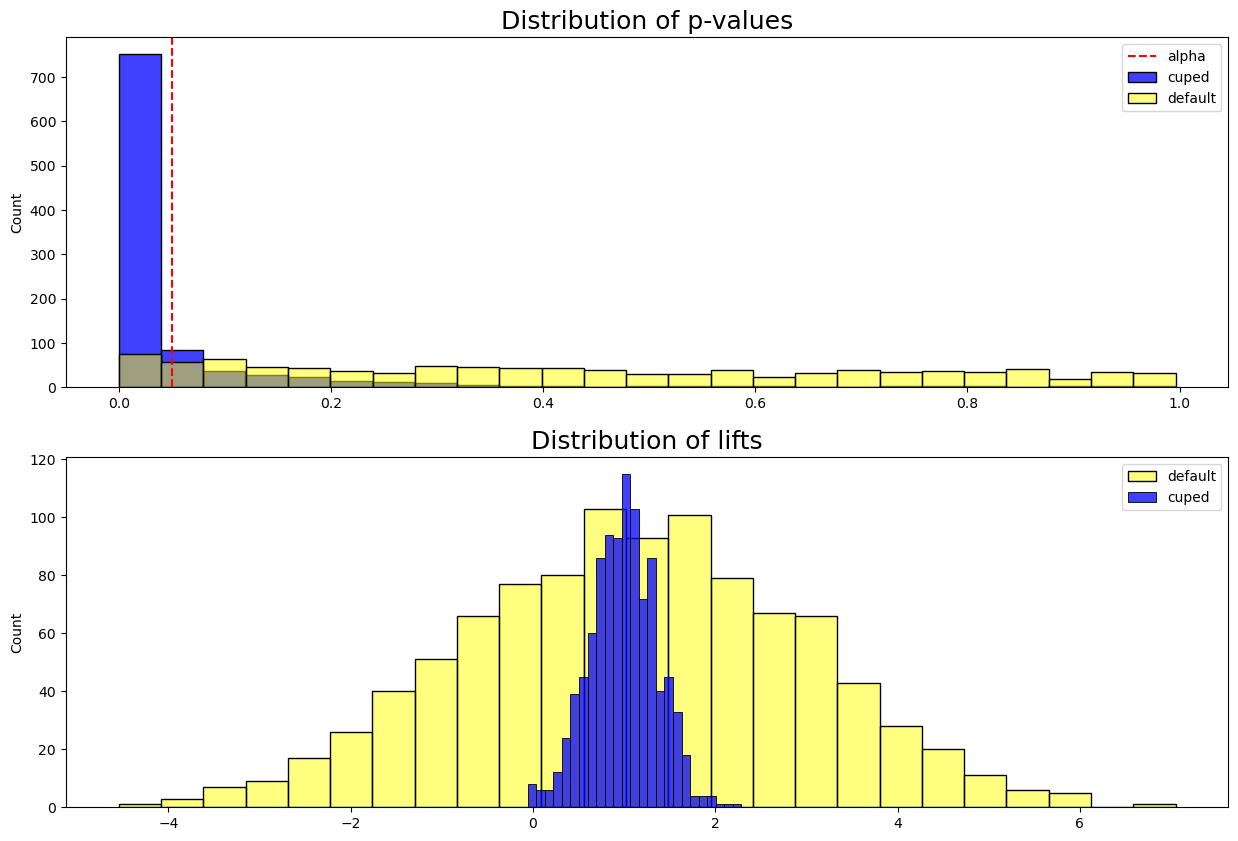

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax = ax.ravel()

sns.histplot(pvalues_cuped, bins=25, color='blue', label='cuped', ax=ax[0])
sns.histplot(pvalues_default, bins=25, color='yellow', alpha=0.5, label='default', ax=ax[0])
ax[0].axvline(0.05, linestyle='dashed', color='red', label='alpha')
ax[0].set_title('Distribution of p-values', fontsize=18)
ax[0].legend()

sns.histplot(lifts_default, bins=25, color='yellow', alpha=0.5, label='default', ax=ax[1])
sns.histplot(lifts_cuped, bins=25, color='blue', label='cuped', ax=ax[1])
ax[1].set_title('Distribution of lifts', fontsize=18)
ax[1].legend();

## Simulation 2 <a class="anchor" id="4"></a>

Here I will also do simulation, but in treatment group instead of lift, would be just noise. Then I will conduct Kolmogorov-Smirnov test on default and cuped metric. So lets see hot test would detect this noise:

In [11]:
def simulate2(N: int, generation_conf: dict) -> tuple[float, float]:
    counter_default = 0
    counter_cuped = 0
    
    for _ in tqdm(range(N)):
        df = get_samples(**generation_conf)
        df = cuped(df)

        a_after = df[df['group'] == 0]['after'].values
        b_after = df[df['group'] == 1]['after'].values
        a_after_cuped = df[df['group'] == 0]['cuped'].values
        b_after_cuped = df[df['group'] == 1]['cuped'].values
        
        if kstest(a_after, b_after).pvalue < 0.05:
            counter_default += 1
            
        if kstest(a_after_cuped, b_after_cuped).pvalue < 0.05:
            counter_cuped += 1
            
    return (counter_default / N, counter_cuped / N)

In [12]:
res = simulate2(
    N = 1000, 
    generation_conf = {'N': 2000, 'mean': 100, 'std': 50, 'std_after': 10, 'lift': np.random.normal(0, 2, 1000)}
)

print(f'Default caught noise in {np.round(res[0] * 100, 2)}% of cases')
print(f'Cuped caught noise in {np.round(res[1] * 100, 2)}% of cases')

100%|█████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.71it/s]

Default caught noise in 4.7% of cases
Cuped caught noise in 6.3% of cases


Firstly seems that nothing special, test on both metrics cannot detect such small noise well. But now I will slightly increasy the noise:

In [13]:
res = simulate2(
    N = 1000, 
    generation_conf = {'N': 2000, 'mean': 100, 'std': 50, 'std_after': 10, 'lift': np.random.normal(0, 5, 1000)}
)

print(f'Default caught noise in {np.round(res[0] * 100, 2)}% of cases')
print(f'Cuped caught noise in {np.round(res[1] * 100, 2)}% of cases')

100%|█████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.96it/s]

Default caught noise in 4.2% of cases
Cuped caught noise in 27.1% of cases


In [14]:
res = simulate2(
    N = 1000, 
    generation_conf = {'N': 2000, 'mean': 100, 'std': 50, 'std_after': 10, 'lift': np.random.normal(0, 10, 1000)}
)

print(f'Default caught noise in {np.round(res[0] * 100, 2)}% of cases')
print(f'Cuped caught noise in {np.round(res[1] * 100, 2)}% of cases')

100%|█████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.14it/s]

Default caught noise in 4.3% of cases
Cuped caught noise in 100.0% of cases


Results of test on default metric remained almost the same, while on cuped metric increased significantly.

## Simulation 3 <a class="anchor" id="5"></a>

Now I wanna provide code more closer to real-world task. As I mentioned it is better to compute mean not only from our "before" metric but from as big approximation of population as possible (as far it is consistent with ab groups). For example you can include data even "before before" for mean computation. Or if you conduct ab test not on whole population(which is almost always), you can just compute mean from whole population (important note: don't compute mean from "after").

Here only part of data would be in ab test, and mean whoud be computed from whole data:

In [15]:
def get_samples_real(
    N: int,
    test_size: int,
    mean: float,
    std: float,
    std_after: float,
    lift: float
) -> pd.DataFrame:
    
    df = pd.DataFrame()
    df['before'] = np.random.normal(mean, std, N)
    df['after'] = df['before'] + np.random.normal(0, std_after, N)
    df['group'] = None
    control_idx = np.random.choice(df.index, test_size//2, replace=False)
    df.loc[control_idx, 'group'] = 0
    treatment_idx = np.random.choice(df[df['group'].isna()].index, test_size//2, replace=False)
    df.loc[treatment_idx, 'group'] = 1
    df.loc[df['group'] == 1, 'after'] += lift
    
    return df

In [16]:
def cuped_real(df: pd.DataFrame, use_theta: bool = True) -> pd.DataFrame:
    
    mean = np.mean(df['before'])
    df = df[~df['group'].isna()]
    
    if use_theta:
        theta = smf.ols('after ~ before', data=df).fit().params[1]
    else:
        theta = 1
        
    df['cuped'] = df['after'] - theta * (df['before'] - mean)
    
    return df.reset_index()

In [17]:
def simulate3(N: int, generation_conf: dict) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    pvalues_default = []
    pvalues_cuped = []
    lifts_default = []
    lifts_cuped = []

    for _ in tqdm(range(N)):
        df_full = get_samples_real(**generation_conf)
        df = cuped_real(df_full)

        a_after = df[df['group'] == 0]['after'].values
        b_after = df[df['group'] == 1]['after'].values
        a_after_cuped = df[df['group'] == 0]['cuped'].values
        b_after_cuped = df[df['group'] == 1]['cuped'].values

        pvalues_default.append(ttest_ind(a_after, b_after).pvalue)
        pvalues_cuped.append(ttest_ind(a_after_cuped, b_after_cuped).pvalue)

        lifts_default.append(np.mean(b_after) - np.mean(a_after))
        lifts_cuped.append(np.mean(b_after_cuped) - np.mean(a_after_cuped))
        
    return (
        np.array(pvalues_default), 
        np.array(pvalues_cuped), 
        np.array(lifts_default), 
        np.array(lifts_cuped)
    )

In [18]:
pvalues_default, pvalues_cuped, lifts_default, lifts_cuped = simulate3(
    1000, 
    {'N': 10000, 'test_size': 2000, 'mean': 100, 'std': 20, 'std_after': 10, 'lift': 2}
)

print_stats(pvalues_default, pvalues_cuped, lifts_default, lifts_cuped)

100%|██████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.44it/s]

Default:  p-values less than 0.05 = 505, mean p-value = 0.1496, variance of p-values = 0.0508324446
          mean of computed lifts = 1.965, variance of lifts = 0.993

Cuped:    p-values less than 0.05 = 999, mean p-value = 0.00095, variance of p-values = 1.59604e-05
          mean of computed lifts = 1.992, variance of lifts = 0.199


## Conclusions <a class="anchor" id="6"></a>

To not repeat I will just say that as it was show before, cuped method helps us to make our test more sensitive, power of test increases significantly.